In [7]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from ipynb_utils import cwd_to_root

In [8]:
cwd_to_root()

Current working directory set to project root: /home/ariel/projects/deep-learning/yolov_mrz


## Utils

In [63]:
def imshow(image, title="Image"):
    plt.title(title)
    plt.imshow(image, cmap="gray")
    plt.axis("off")


def crop_bbox(image_path, results, right_padding=30):
    image = cv2.imread(image_path)

    prob = -1
    result = None
    idx = 0
    for tmp_result in results:
        for i, tmp_prob in enumerate(tmp_result.cpu().boxes.conf):
            if tmp_prob > prob:
                prob = tmp_prob
                result = tmp_result
                idx = i

    left, top, right, bottom = [
        int(round(cord)) for cord in result.boxes[idx].xyxy.squeeze(0).tolist()
    ]

    # height, width, channels
    cropped_image = image[
        top:bottom,
        left : right
        + (
            right_padding
            if image.shape[1] - right > right_padding
            else image.shape[1] - right
        ),
    ]

    imshow(cropped_image)
    return cropped_image

In [16]:
from typing import Tuple
from concurrent.futures import ThreadPoolExecutor
import multiprocessing


def rotate_image(image, angle) -> np.ndarray:
    """
    Rotates an image by a given angle.

    Parameters:
    - image: A numpy array representing the image to be rotated.
    - angle: A float representing the angle by which the image should be rotated.

    Returns:
    - A numpy array representing the rotated image.
    """
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    m = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(
        image,
        m,
        (w, h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REPLICATE,
    )


def determine_score(arr) -> np.ndarray:
    """
    Calculate the score of an array based on its histogram.

    Parameters:
        arr (numpy.ndarray): The input array.

    Returns:
        numpy.ndarray: The score of the array.
    """
    histogram = np.sum(arr, axis=2, dtype=float)
    return np.sum((histogram[..., 1:] - histogram[..., :-1]) ** 2, axis=1, dtype=float)


def correct_skew(image, limit=5, delta=1) -> Tuple[np.ndarray, float]:
    """
    Corrects the skew of an image.

    Parameters:
        image (numpy.ndarray): The input image.
        limit (int): The upper limit of the angle range for rotation. Default is 5.
        delta (int): The step size for the angle range. Default is 1.

    Returns:
        tuple: A tuple containing the corrected image and the best angle for rotation.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Rotate images in parallel
    angles = np.arange(-limit, limit + delta, delta)

    # num_cores = multiprocessing.cpu_count()
    with ThreadPoolExecutor() as executor:
        img_stack = np.stack(
            list(executor.map(lambda angle: rotate_image(thresh, angle), angles)),
            axis=0,
        )

    # Compute scores
    scores = determine_score(img_stack)
    best_angle = angles[np.argmax(scores)]

    # Correct the skew
    corrected = rotate_image(image, best_angle)
    return corrected, best_angle


def auto_rotate(image, limit=30, delta=1) -> Tuple[np.ndarray, float]:
    """
    Rotates an image to correct its skew and returns the corrected image and the angle of rotation.

    Parameters:
        image (np.ndarray): The input image to be rotated.
        limit (int, optional): The maximum angle of rotation allowed. Default is 30.
        delta (int, optional): The step size for rotation. Default is 1.

    Returns:
        corrected (np.ndarray): The corrected image after rotation.
        angle (float): The angle of rotation applied to the image.
    """
    corrected, angle = correct_skew(image, limit=limit, delta=delta)
    return corrected, angle

## Train

In [10]:
model = YOLO("models/yolov8n.pt")

In [ ]:
model.train(data="mrz_train_config.yml", epochs=100)

In [18]:
model.export(format="torchscript")

Ultralytics YOLOv8.1.29 🚀 Python-3.10.13 torch-2.2.1 CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)

PyTorch: starting from 'D:\dev\ml\projects\deep_learning\yolov_mrz\runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

TorchScript: starting export with torch 2.2.1...
TorchScript: export success ✅ 1.5s, saved as 'D:\dev\ml\projects\deep_learning\yolov_mrz\runs\detect\train\weights\best.torchscript' (11.9 MB)

Export complete (3.1s)
Results saved to D:\dev\ml\projects\deep_learning\yolov_mrz\runs\detect\train\weights
Predict:         yolo predict task=detect model=D:\dev\ml\projects\deep_learning\yolov_mrz\runs\detect\train\weights\best.torchscript imgsz=640  
Validate:        yolo val task=detect model=D:\dev\ml\projects\deep_learning\yolov_mrz\runs\detect\train\weights\best.torchscript imgsz=640 data=mrz_train_config.yml  
Visualize:       https://netron.app


'D:\\dev\\ml\\projects\\deep_learning\\yolov_mrz\\runs\\detect\\train\\weights\\best.torchscript'

## Predict

In [34]:
model = YOLO(
    "/home/ariel/projects/deep-learning/yolov_mrz/models/best.torchscript",
    task="detect",
)

In [69]:
image_path = (
    "/home/ariel/projects/deep-learning/yolov_mrz/data/images/val/PRTIDCard-back.jpg"
)

results = model(image_path)


image 1/1 /home/ariel/projects/deep-learning/yolov_mrz/data/images/val/PRTIDCard-back.jpg: 640x640 2 MRZs, 3.0ms
Speed: 2.1ms preprocess, 3.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    # result.save(filename="result.jpg")

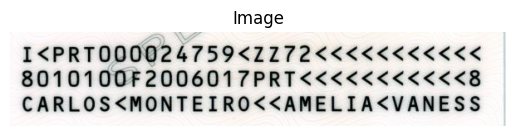

In [71]:
cropped_image = crop_bbox(image_path, results)

In [72]:
corrected, angle = auto_rotate(cropped_image, limit=30, delta=1)

Best Angle: 0 degrees


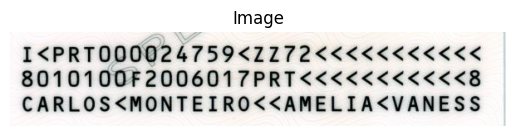

In [73]:
print(f"Best Angle: {angle} degrees")
imshow(corrected)

## Segmentation

In [24]:
model = YOLO("models/yolov8n-seg.pt")

In [25]:
results = model("https://ultralytics.com/images/bus.jpg")

100%|██████████| 134k/134k [00:00<00:00, 3.16MB/s]


image 1/1 /home/ariel/projects/deep-learning/yolov_mrz/bus.jpg: 640x480 4 persons, 1 bus, 1 skateboard, 111.3ms
Speed: 2.1ms preprocess, 111.3ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 480)


In [ ]:
for result in results:
    result.show()
    # result.save(filename="seg_result.jpg")

In [ ]:
import locale

locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!yolo predict model=yolov8n-seg.pt source='https://ultralytics.com/images/bus.jpg'

Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs

image 1/1 /content/data/images/train/id_card_13.jpg: 384x640 (no detections), 138.8ms
Speed: 3.1ms preprocess, 138.8ms inference, 24.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict
